<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!tar -xvf drive/MyDrive/tile.tar.gz tile

Mounted at /content/drive


In [3]:
# Get a list of all image file paths in the test set (YW: added "recursive=True")
file_paths = glob.glob('drive/MyDrive/tile/test/*/*.png', recursive=True)

# Sort the file paths to ensure consistent order
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

In [4]:
all_data = []
# Load and preprocess the images
for img in tqdm(file_paths):
    # Read the image using OpenCV
    img = cv2.imread(img)

    # Convert the image from BGR to RGB format
    img = img[..., ::-1]

    # Append the processed image to the list
    all_data.append(img)

# Convert the list of images to a NumPy array
all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/60 [00:00<?, ?it/s]

(60, 840, 840, 3)


Classes: ['crack', 'glue_strip', 'good', 'gray_stroke', 'oil', 'rough']


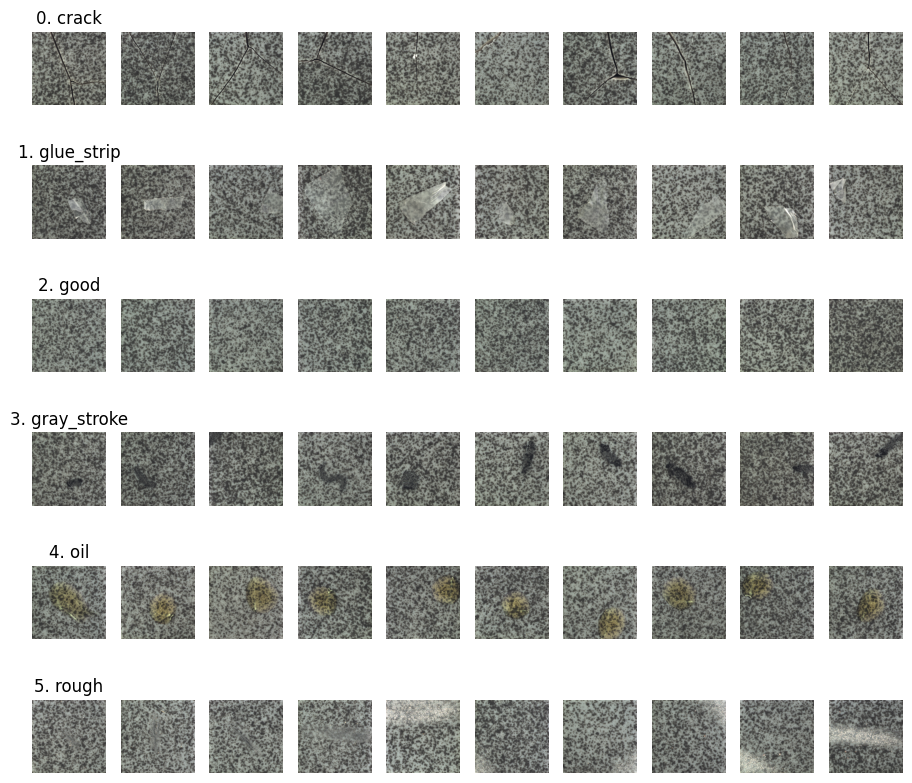

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get the unique class names from the file paths
classes = sorted(set([path.split('/')[-2] for path in file_paths]))
print(f'Classes: {classes}')

# Calculate the number of images per class
images_per_class = len(all_data) // len(classes)

# Plot sample images for each class
fig, axs = plt.subplots(len(classes), 10, figsize=(9, 6 * 10))

for i, class_name in enumerate(classes):
    # Calculate the starting index for the current class
    index = i * images_per_class

    # Plot two sample images for the class
    for j in range(10):
        axs[i, 0].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
# Adjust spacing between subplots (reduce top space)
plt.subplots_adjust(top=0.15)  # Adjust top value based on your needs
plt.show()

## A. Data Loading and Preprocessing

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Split the data into training and validation sets
num_classes = 6
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# Transpose the data to the expected format for PyTorch models
# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

# Print the shapes of the training and validation data
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (48, 3, 840, 840)
Shape of x_val: (12, 3, 840, 840)
Shape of y_train: (48,)
Shape of y_val: (12,)


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define the transformations for the training and validation datasets
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# Create a custom dataset class
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        # Transpose the image to the correct format for PyTorch models
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        # Apply the transformations
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [8]:
batch_size = 8

# Create training and validation datasets
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

# Create data loaders for training and validation datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

###-----changed here------###
# model = models.resnet50(weights='IMAGENET1K_V1')
model = models.densenet121(pretrained=True)  # Using DenseNet121

# ConvNet as fixed feature extractor (freeze early layers only)
layer = 0
###-----changed here------###
# Adjusting for the DenseNet structure
for param in model.features.parameters():
    layer += 1
    if layer < len(list(model.features.parameters())) // 2:  # Freeze the first half of the layers
        param.requires_grad = False

# ConvNet as fixed feature extractor (freeze parameters)
#for param in model.parameters():
#    param.requires_grad = False

###-----changed here------###
# Adjusting for the DenseNet structure
num_ftrs = model.classifier.in_features
num_class = 6

###-----changed here------###
# Change # of class from 1000 into 6 in the last layer for DenseNet
model.classifier = nn.Linear(num_ftrs, num_class)  # Adjusting the classifier for 6 classes

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## C. Training the Neural Network

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100 #### starting from 50
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-5) #### starting lr@1e-3
#optimizer_rms = optim.RMSprop(model.parameters(), lr=1e-3)  ### try RMSprop
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.99) #### try SGD


###=====CHANGED HERE =========###
#lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0.001)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/100, Train loss: 1.8312, Train acc: 16.6667%, Val loss: 1.9022, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 2/100, Train loss: 1.7718, Train acc: 29.1667%, Val loss: 2.4229, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 3/100, Train loss: 1.6429, Train acc: 35.4167%, Val loss: 3.2299, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 4/100, Train loss: 1.6770, Train acc: 22.9167%, Val loss: 3.5054, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 5/100, Train loss: 1.2741, Train acc: 56.2500%, Val loss: 10.2026, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 6/100, Train loss: 1.3531, Train acc: 45.8333%, Val loss: 26.5582, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 7/100, Train loss: 1.4519, Train acc: 47.9167%, Val loss: 39.8787, Val acc: 16.6667%, Best Val loss: 1.9022 Best Val acc: 16.67%
Epoch 8/100, Train loss: 1.3671, Train acc: 60.4167%, Val l

### Visualizing model performance

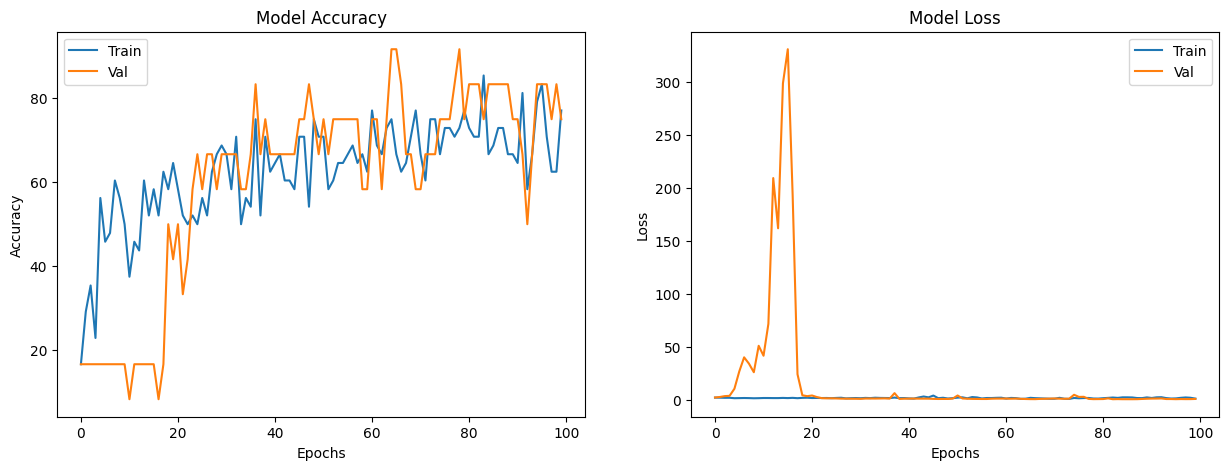

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [12]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 1, 1, 2, 1, 3, 3], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3], device='cuda:0')
tensor([4, 4, 5, 5], device='cuda:0')
tensor([4, 4, 5, 5], device='cuda:0')
Test accuracy is 91.66666666666667%
